In [1]:
import os
import platform

OS_PREFIX = "D:/data" if platform.system() == "Windows" else ""
DATA_PATH = OS_PREFIX + "/kaggle/input/lgg-mri-segmentation/kaggle_3m/"

In [2]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

plt.style.use("dark_background")

In [3]:
# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

In [4]:
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: D:/data/kaggle/input/lgg-mri-segmentation/kaggle_3m\data.csv
This is not a dir: D:/data/kaggle/input/lgg-mri-segmentation/kaggle_3m\README.md


,dirname,path
0,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...
1,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...
2,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...
3,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...
4,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...


In [5]:
# Masks/No masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: D:/data/kaggle/input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3.tif 
Path to the Mask: D:/data/kaggle/input/lgg-mri-segmentation/kaggle_3m\TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3_mask.tif


In [6]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
1,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
2,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
3,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
4,kaggle_3m\TCGA_CS_4941_19960909,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
...,...,...,...,...
3924,kaggle_3m\TCGA_HT_A61B_19991127,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
3925,kaggle_3m\TCGA_HT_A61B_19991127,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
3926,kaggle_3m\TCGA_HT_A61B_19991127,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0
3927,kaggle_3m\TCGA_HT_A61B_19991127,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,D:/data/kaggle/input/lgg-mri-segmentation/kagg...,0


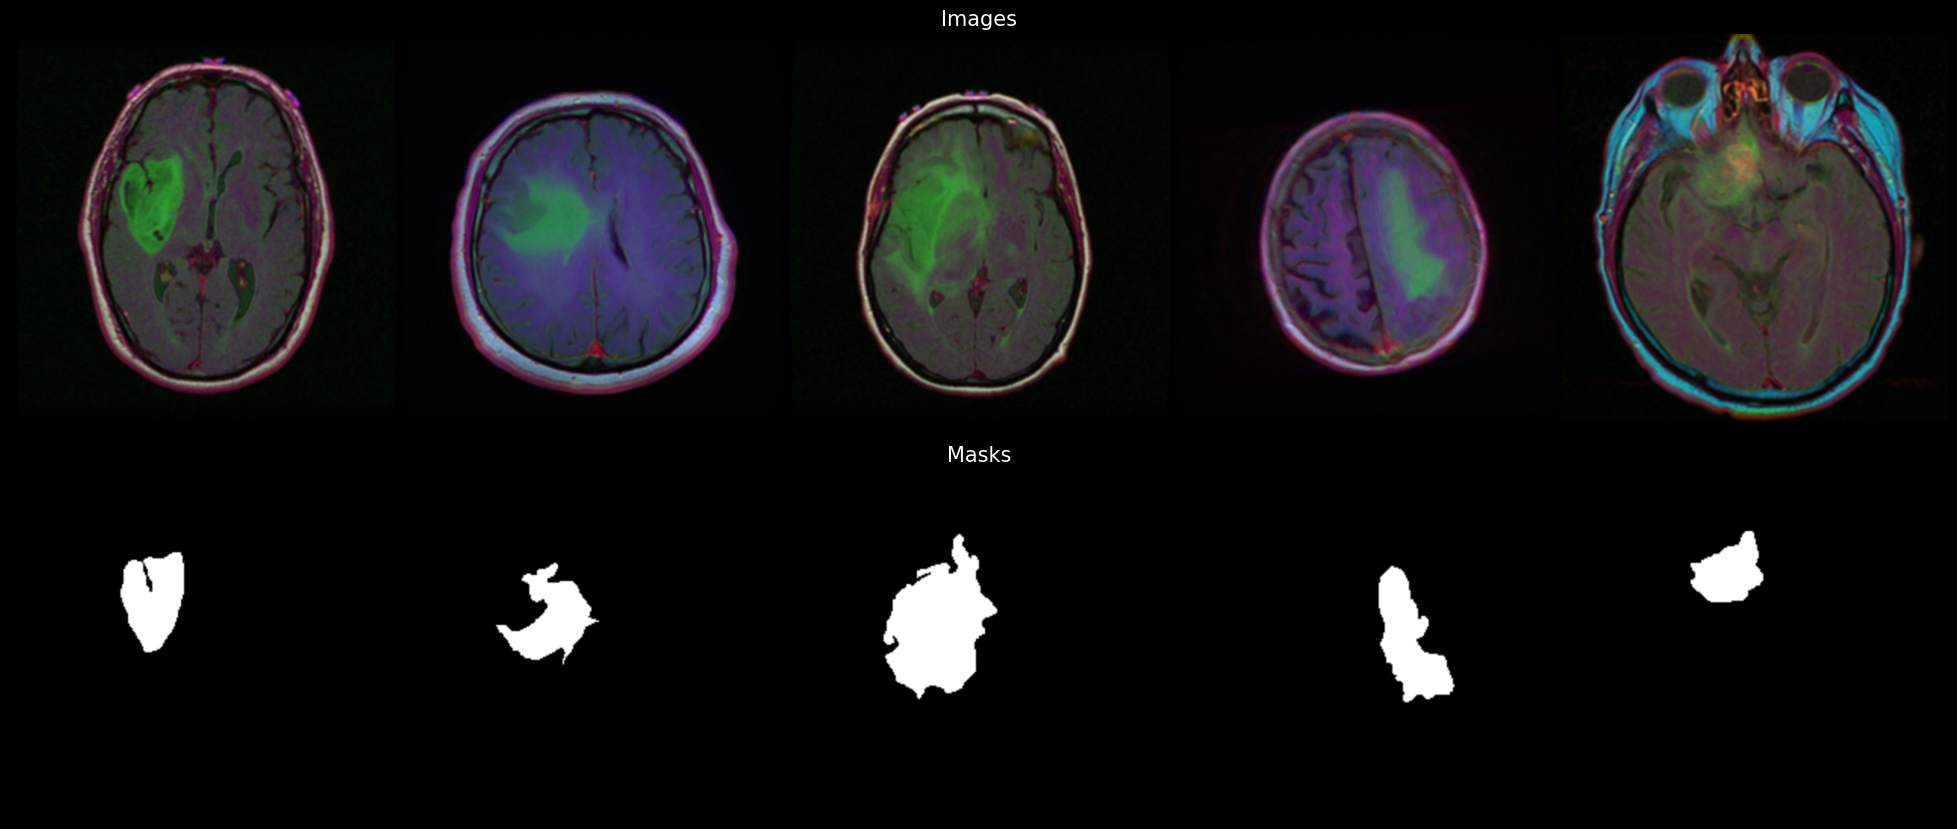

In [7]:
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(2, 1),
                 axes_pad=0.1,
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()